# Data Preprocessing
## PyTorch Dataset, Augmentation & DataLoaders

This notebook prepares the data for model training:
- Custom PyTorch Dataset class
- Data augmentation strategies
- Stratified train/val/test split (by lesion_id to prevent leakage)
- DataLoader setup with appropriate transforms

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
!pwd


/Users/sujanbhattarai/deep_learning/notebooks


In [3]:
# 2. Define your subfolders
# Current notebook folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(PROJECT_ROOT, 'data', 'ham10000')

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')

## 1. Load Metadata and Setup

In [4]:
# Use existing directories
# PROJECT_ROOT and DATA_DIR are already defined
ham10000_dir = os.path.join(DATA_DIR, 'ham10000')

# Load metadata
metadata_path = os.path.join(ham10000_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

# Class mapping
class_names = sorted(df['dx'].unique())  # sorted ensures consistent order
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print(f"\nClass mapping:")
for name, idx in class_to_idx.items():
    print(f"  {name}: {idx}")

# Add numeric labels to dataframe
df['label'] = df['dx'].map(class_to_idx)



Class mapping:
  akiec: 0
  bcc: 1
  bkl: 2
  df: 3
  mel: 4
  nv: 5
  vasc: 6


In [5]:
# Helper function to get image path
def get_image_path(image_id):
    path1 = os.path.join(ham10000_dir, 'HAM10000_images_part_1', f'{image_id}.jpg')
    path2 = os.path.join(ham10000_dir, 'HAM10000_images_part_2', f'{image_id}.jpg')
    return path1 if os.path.exists(path1) else path2

In [6]:
lesion_df = df.groupby('lesion_id')['dx'].first().reset_index()
lesion_df['label'] = lesion_df['dx'].map(class_to_idx)
lesion_df.head()

,lesion_id,dx,label
0,HAM_0000000,nv,5
1,HAM_0000001,bkl,2
2,HAM_0000002,mel,4
3,HAM_0000003,nv,5
4,HAM_0000004,nv,5


## 2. Stratified Train/Val/Test Split

**Critical**:  Split by `lesion_id` to ensure the same lesion doesn't appear in both train and test sets.

In [7]:
# Get unique lesions with their labels
lesion_df = df.groupby('lesion_id')['dx'].first().reset_index()
lesion_df['label'] = lesion_df['dx'].map(class_to_idx)

print(f"Total unique lesions: {len(lesion_df)}")
print(f"Class distribution in unique lesions:")
print(lesion_df['dx'].value_counts())

Total unique lesions: 7470
Class distribution in unique lesions:
dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64


In [8]:
# Split: 70% train, 15% val, 15% test
train_lesions, temp_lesions = train_test_split(
    lesion_df['lesion_id'].values,
    test_size=0.3,
    stratify=lesion_df['label'].values,
    random_state=42
)

In [9]:
# Further split temp into val and test (15% each)
val_lesions, test_lesions = train_test_split(
    temp_lesions,
    test_size=0.5,
    stratify=lesion_df[lesion_df['lesion_id'].isin(temp_lesions)]['label'].values,
    random_state=42
)

In [10]:
# Create train/val/test dataframes
train_df = df[df['lesion_id'].isin(train_lesions)].reset_index(drop=True)
val_df = df[df['lesion_id'].isin(val_lesions)].reset_index(drop=True)
test_df = df[df['lesion_id'].isin(test_lesions)].reset_index(drop=True)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_df)} images from {len(train_lesions)} lesions")
print(f"  Val:   {len(val_df)} images from {len(val_lesions)} lesions")
print(f"  Test:  {len(test_df)} images from {len(test_lesions)} lesions")


Split sizes:
  Train: 6981 images from 5229 lesions
  Val:   1515 images from 1120 lesions
  Test:  1519 images from 1121 lesions


In [11]:
# Verify no overlap
train_set = set(train_lesions)
val_set = set(val_lesions)
test_set = set(test_lesions)

assert len(train_set & val_set) == 0, "Train and val have overlapping lesions!"
assert len(train_set & test_set) == 0, "Train and test have overlapping lesions!"
assert len(val_set & test_set) == 0, "Val and test have overlapping lesions!"
print("\n✅ No data leakage - lesions are properly separated!")


✅ No data leakage - lesions are properly separated!


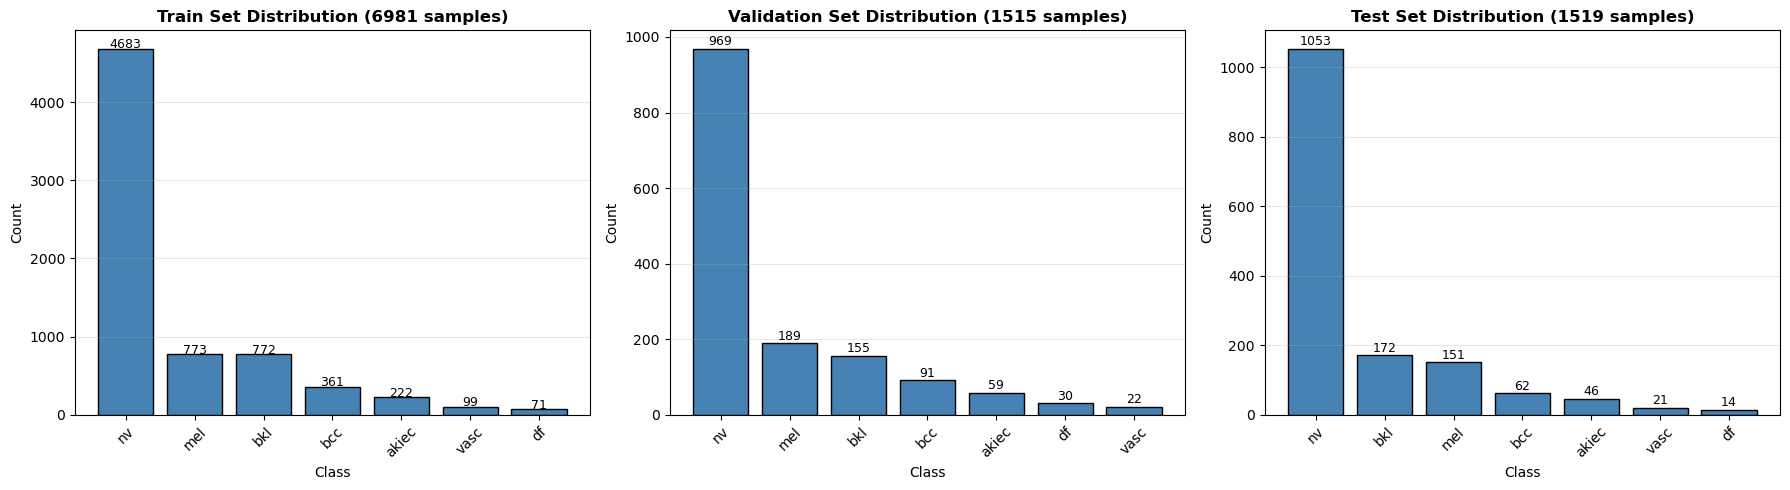

In [12]:
# Visualize class distribution in each split
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_df, title) in enumerate([(train_df, 'Train'), (val_df, 'Validation'), (test_df, 'Test')]):
    class_counts = split_df['dx'].value_counts()
    axes[idx].bar(class_counts.index, class_counts.values, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{title} Set Distribution ({len(split_df)} samples)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, v in enumerate(class_counts.values):
        axes[idx].text(i, v + 10, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Calculate Class Weights for Imbalanced Data

We'll use these weights in the loss function to handle class imbalance.

In [13]:
# Calculate class weights (inverse frequency)
class_counts = train_df['dx'].value_counts().sort_index()
class_weights = 1.0 / class_counts.values
class_weights = class_weights / class_weights.sum() * len(class_names)

print("Class weights for loss function:")
for name, weight in zip(class_names, class_weights):
    print(f"  {name}: {weight:.4f}")

Class weights for loss function:
  akiec: 0.9203
  bcc: 0.5659
  bkl: 0.2646
  df: 2.8775
  mel: 0.2643
  nv: 0.0436
  vasc: 2.0637


In [14]:
# Convert to tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# Do this:
save_path = os.path.join(MODELS_DIR, 'class_weights.npy')
np.save(save_path, class_weights)
print(f"✅ Saved to: {save_path}")

✅ Saved to: /Users/sujanbhattarai/deep_learning/models/class_weights.npy


## 4. Define Data Augmentation & Transforms

Different transforms for training (with augmentation) and validation/test (without augmentation).

In [15]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# Image parameters
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Training transforms with aggressive augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

print("Transform pipelines created:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Normalization: ImageNet statistics")
print(f"  Training augmentations: Flips, Rotation, ColorJitter, Affine")

Transform pipelines created:
  Image size: 224x224
  Normalization: ImageNet statistics
  Training augmentations: Flips, Rotation, ColorJitter, Affine


## 5. Custom PyTorch Dataset Class

## 6. Create Dataset Instances

In [16]:
from my_data_utils import SkinLesionDataset

data_dir = os.path.join(PROJECT_ROOT, 'data', 'ham10000')
train_dataset = SkinLesionDataset(train_df, data_dir, transform=train_transform)
val_dataset = SkinLesionDataset(val_df, data_dir, transform=val_transform)
test_dataset = SkinLesionDataset(test_df, data_dir, transform=val_transform)

print(f"Dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val:   {len(val_dataset)}")
print(f"  Test:  {len(test_dataset)}")

sample_img, sample_label = train_dataset[0]
print(f"\nSample image shape: {sample_img.shape}")
print(f"Sample label: {sample_label} ({idx_to_class[sample_label]})")
print(f"Image tensor range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")

 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/6981 [00:00<?, ?it/s]

 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/1515 [00:00<?, ?it/s]

 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/1519 [00:00<?, ?it/s]

Dataset sizes:
  Train: 6981
  Val:   1515
  Test:  1519

Sample image shape: torch.Size([3, 224, 224])
Sample label: 2 (bkl)
Image tensor range: [-2.118, 2.431]


## 7. Visualize Augmentations

In [17]:
def denormalize(tensor, mean=IMG_MEAN, std=IMG_STD):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

sample_idx = 10
image_id = train_df.loc[sample_idx, 'image_id']
img_path = get_image_path(image_id)
original_img = Image.open(img_path).convert('RGB')

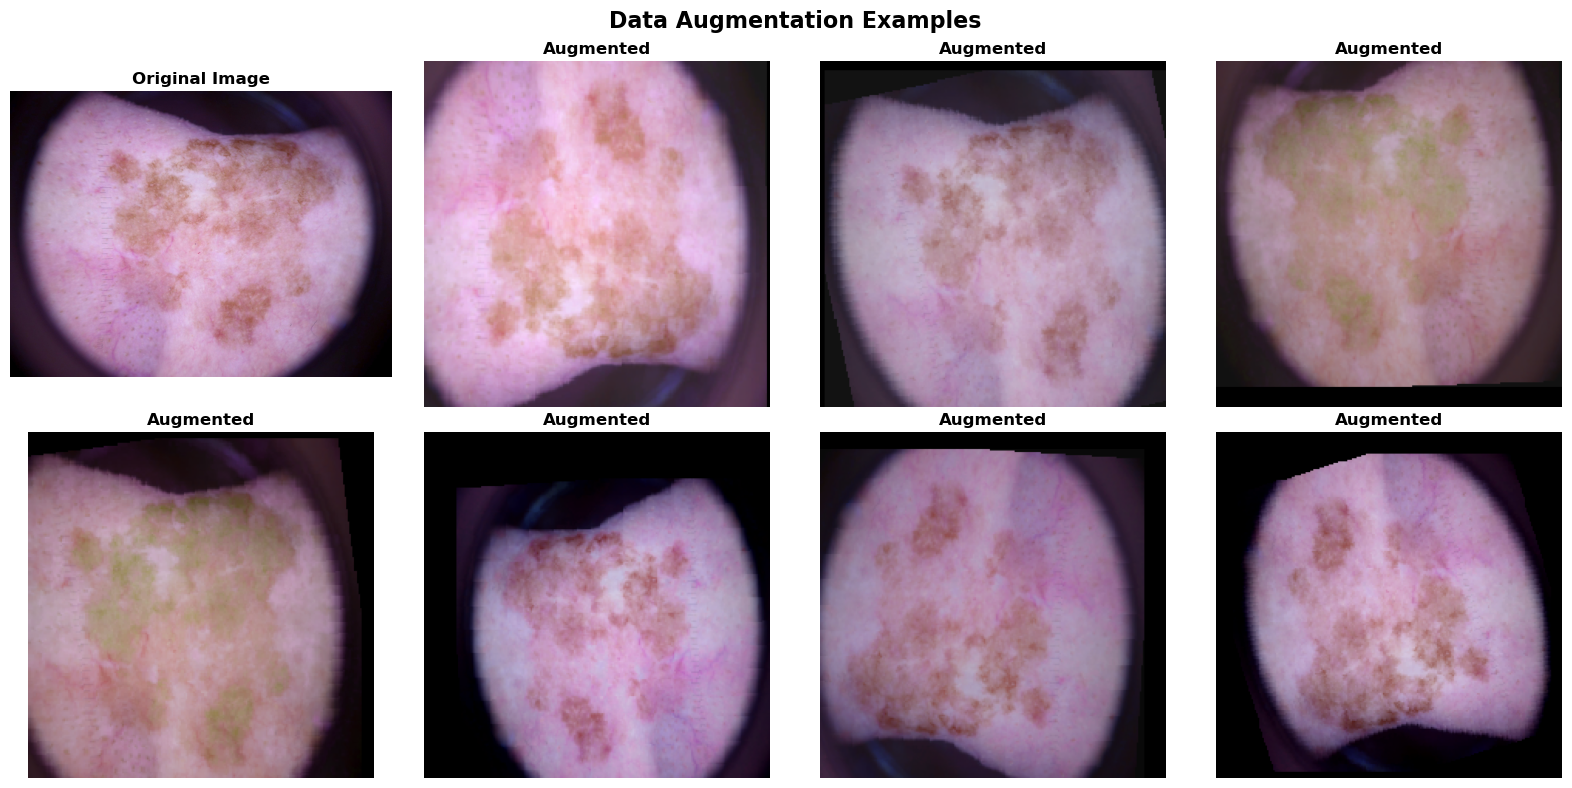

✅ Augmentation pipeline verified


In [18]:
# plotting augmentation examples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

axes[0, 0].imshow(original_img)
axes[0, 0].set_title('Original Image', fontweight='bold')
axes[0, 0].axis('off')

positions = [(0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
for pos in positions:
    aug_img = train_transform(original_img)
    aug_img_denorm = denormalize(aug_img.clone())
    aug_img_np = aug_img_denorm.permute(1, 2, 0).numpy()
    aug_img_np = np.clip(aug_img_np, 0, 1)
    
    axes[pos].imshow(aug_img_np)
    axes[pos].set_title('Augmented', fontweight='bold')
    axes[pos].axis('off')

plt.tight_layout()
plt.show()

print("✅ Augmentation pipeline verified")

## 8. Create DataLoaders

In [19]:
NUM_WORKERS = 4
Batch_Size = 32

# Change this in your DataLoader definition
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0  # Set to 0 for interactive testing/debugging
)

# Now this will work perfectly:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")

Batch shape: torch.Size([32, 3, 224, 224])


In [20]:
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    # Set to False because MPS uses Unified Memory
    pin_memory=False, 
    # This keeps the worker processes alive between epochs for speed
    persistent_workers=True if NUM_WORKERS > 0 else False 
)

In [21]:
# Create DataLoader for test set
test_loader = DataLoader(
    test_dataset,
    batch_size=Batch_Size,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoader Configuration:")
print(f"  Batch size: {Batch_Size}")
print(f"  Num workers: {NUM_WORKERS}")
print(f"  Pin memory: {torch.cuda.is_available()}")
print(f"\nNumber of batches:")
print(f"  Train: {len(train_loader)}")
print(f"  Val:   {len(val_loader)}")
print(f"  Test:  {len(test_loader)}")

DataLoader Configuration:
  Batch size: 32
  Num workers: 4
  Pin memory: False

Number of batches:
  Train: 219
  Val:   48
  Test:  48


## 9. Verify DataLoader with Sample Batch

In [22]:
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Batch size: {images.size(0)}")
print(f"Image dimensions: {images.size(1)} channels, {images.size(2)}x{images.size(3)} pixels")
print(f"\nLabel distribution in batch:")
for label in labels.unique():
    count = (labels == label).sum().item()
    print(f"  Class {label} ({idx_to_class[label.item()]}): {count} samples")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Batch size: 32
Image dimensions: 3 channels, 224x224 pixels

Label distribution in batch:
  Class 0 (akiec): 1 samples
  Class 1 (bcc): 2 samples
  Class 2 (bkl): 2 samples
  Class 4 (mel): 4 samples
  Class 5 (nv): 22 samples
  Class 6 (vasc): 1 samples


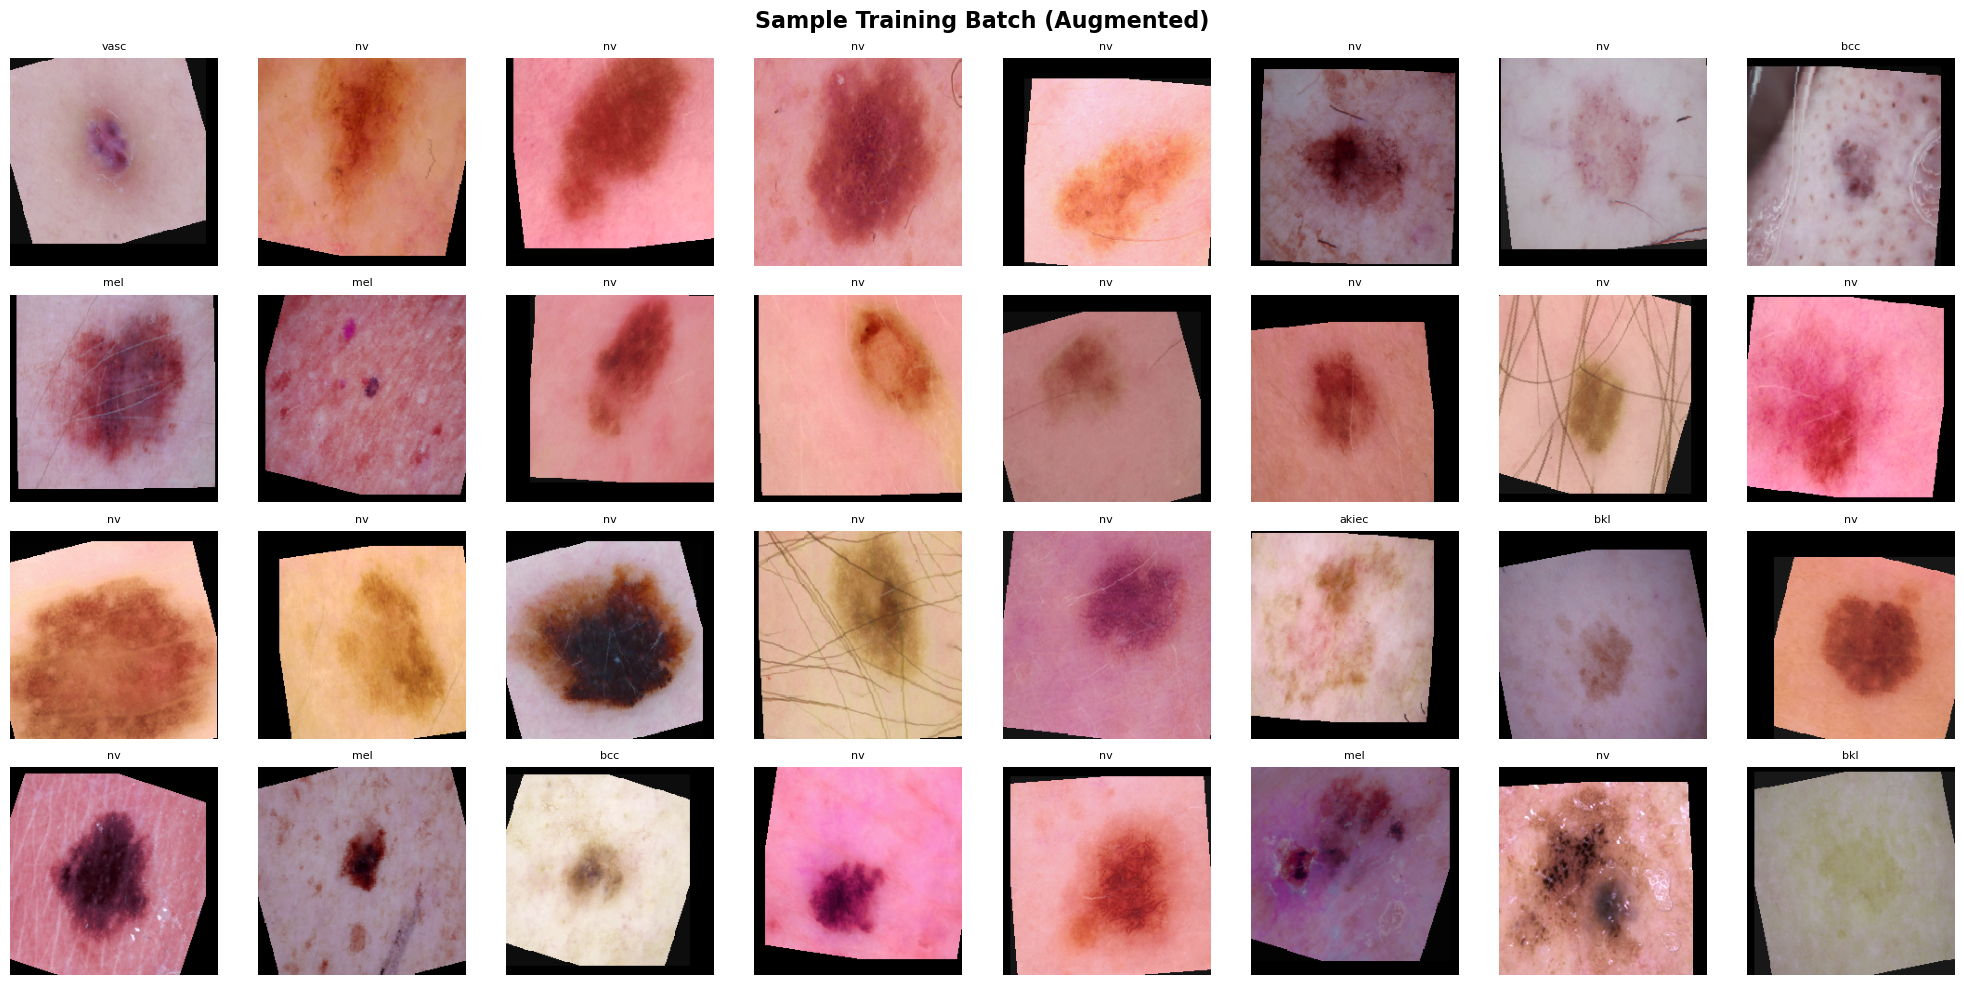

In [23]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Sample Training Batch (Augmented)', fontsize=16, fontweight='bold')

for idx in range(min(32, len(images))):
    row = idx // 8
    col = idx % 8
    
    img = denormalize(images[idx].clone())
    img_np = img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f"{idx_to_class[labels[idx].item()]}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 10. Save Preprocessed Data Information

In [24]:
import os
import json
import numpy as np

# 1. Force the correct paths
BASE_PATH = '/Users/sujanbhattarai/deep_learning/data'
DATA_DIR = os.path.join(BASE_PATH, 'data')
MODELS_DIR = os.path.join(BASE_PATH, 'models')

# 2. Ensure folders exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# 3. Save JSON Split Info
split_info = {
    'train_lesions': train_lesions.tolist() if 'train_lesions' in locals() else [],
    'val_lesions': val_lesions.tolist() if 'val_lesions' in locals() else [],
    'test_lesions': test_lesions.tolist() if 'test_lesions' in locals() else [],
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df)
}

json_path = os.path.join(DATA_DIR, 'split_info.json')
with open(json_path, 'w') as f:
    json.dump(split_info, f, indent=2)

# 4. Save DataFrames to CSV
train_df.to_csv(os.path.join(DATA_DIR, 'train_split.csv'), index=False)
val_df.to_csv(os.path.join(DATA_DIR, 'val_split.csv'), index=False)
test_df.to_csv(os.path.join(DATA_DIR, 'test_split.csv'), index=False)

# 5. Save Class Weights
weights_path = os.path.join(MODELS_DIR, 'class_weights.npy')
np.save(weights_path, class_weights)

print(f"✅ SUCCESS! Files saved to:")
print(f"   📂 {json_path}")
print(f"   📂 {weights_path}")

✅ SUCCESS! Files saved to:
   📂 /Users/sujanbhattarai/deep_learning/data/data/split_info.json
   📂 /Users/sujanbhattarai/deep_learning/data/models/class_weights.npy


## 11. Summary & Next Steps

In [25]:
print("="*70)
print("DATA PREPROCESSING SUMMARY")
print("="*70)

print("\n COMPLETED TASKS:")
print("  1. Stratified train/val/test split by lesion_id (70/15/15)")
print("  2. No data leakage - verified lesion separation")
print("  3. Calculated class weights for imbalanced data")
print("  4. Defined augmentation pipeline for training")
print("  5. Created custom PyTorch Dataset class")
print("  6. Set up DataLoaders with proper configuration")

print("\n DATASET STATISTICS:")
print(f"  Train: {len(train_dataset):,} images")
print(f"  Val:   {len(val_dataset):,} images")
print(f"  Test:  {len(test_dataset):,} images")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {Batch_Size}")
print(f"  Number of classes: {len(class_names)}")

print("\n KEY PREPROCESSING DECISIONS:")
print("  • ImageNet normalization for transfer learning compatibility")
print("  • Aggressive augmentation to combat overfitting")
print("  • Lesion-based splitting prevents data leakage")
print("  • Class weights prepared for weighted loss")

print("\n" + "="*70)
print("READY FOR MODELING!")
print("Next: Notebook 3 - Baseline Model Training")
print("="*70)

DATA PREPROCESSING SUMMARY

 COMPLETED TASKS:
  1. Stratified train/val/test split by lesion_id (70/15/15)
  2. No data leakage - verified lesion separation
  3. Calculated class weights for imbalanced data
  4. Defined augmentation pipeline for training
  5. Created custom PyTorch Dataset class
  6. Set up DataLoaders with proper configuration

 DATASET STATISTICS:
  Train: 6,981 images
  Val:   1,515 images
  Test:  1,519 images
  Image size: 224x224
  Batch size: 32
  Number of classes: 7

 KEY PREPROCESSING DECISIONS:
  • ImageNet normalization for transfer learning compatibility
  • Aggressive augmentation to combat overfitting
  • Lesion-based splitting prevents data leakage
  • Class weights prepared for weighted loss

READY FOR MODELING!
Next: Notebook 3 - Baseline Model Training
